In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import math
import random

/anaconda2/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error

In [3]:
import shap

In [4]:
from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact
from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol
from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda
from ta import add_all_ta_features
from ta.utils import dropna
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [5]:
from mlfinlab.backtest_statistics import sharpe_ratio
from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
from mlfinlab.backtest_statistics import deflated_sharpe_ratio
from mlfinlab.backtest_statistics import information_ratio
from mlfinlab.backtest_statistics import minimum_track_record_length
from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [6]:
from yahoofinancials import YahooFinancials

In [7]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

# Modeling and Training Routines

In [8]:
def create_model():
    clf=RandomForestClassifier(n_estimators=1,
                               criterion='entropy',
                               bootstrap=False,
                               class_weight='balanced_subsample')
    clf=BaggingClassifier(base_estimator=clf,
                         n_estimators=100,
                         max_features=1.)
    return clf

In [9]:
def train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test):
    mmcs, pred_prs = [], []
    for n in range(N_SAMPLES):

        clf = create_model()

        clf.fit(X_train, Y_train)
        pred = clf.predict(X_test)
        pred_pr = clf.predict_proba(X_test)[:, 1]

        mmcs.append(matthews_corrcoef(Y_test, pred))
        pred_prs.append(pred_pr)
    return mmcs, pred_prs

def visualize_mmcs(mmcs):
    plt.figure()
    plt.title(str(np.mean(mmcs)))
    plt.hist(mmcs)
    plt.axvline(np.mean(mmcs), color = 'red')
    plt.show()
    
def backtest_predictions(pred_prs, P_test):
    bagging_strategies, bagging_returns = [], []
    for pred_pr in pred_prs:
        signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
        bagging_strategies.append((signal * P_test).cumsum())
        bagging_returns.append(signal * P_test)
    return bagging_strategies, bagging_returns

def visualize_backtests(bagging_strategies, P_test):
    plt.figure(figsize = (15, 5))
    for strategy in bagging_strategies:
        plt.plot(strategy, color = 'grey', ls = '--', lw=0.5)
    plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
    plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')
    plt.legend()
    plt.show()

# Dataset Routines

In [10]:
def ohclv_to_features(data):
    
    try:
        frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)
    except:
        print('Not calculated')
        frac_diff_series = pd.DataFrame(np.log(data['close'])).pct_change()
        
    # Add all ta features
    technical_features = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume")
    
    data['feat_tech_volume_cmf'] = technical_features['volume_cmf']
    data['feat_tech_volatility_dcl'] = technical_features['volatility_dcl']
    data['feat_tech_trend_macd_diff'] = technical_features['trend_macd_diff']
    data['feat_tech_trend_vortex_ind_diff'] = technical_features['trend_vortex_ind_diff']
    data['feat_tech_momentum_stoch_signal'] = technical_features['momentum_stoch_signal']
    data['feat_tech_momentum_tsi'] = technical_features['momentum_tsi']
    
    data['feat_afml_roll_measure'] = get_roll_measure(data['close'], WINDOW)
    data['feat_afml_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
    data['feat_afml_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
    data['feat_afml_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
    data['feat_afml_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
    data['feat_afml_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
    data['feat_afml_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)
    
    data['feat_stat_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
    data['feat_stat_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
    data['feat_stat_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
    data['feat_stat_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
    data['feat_stat_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
    data['feat_stat_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
    data['feat_stat_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)
    
    FEATURE_COLUMNS = [d for d in data.columns if 'feat_' in d]
    dataset = data[FEATURE_COLUMNS]
    
    dataset_normalized = {}
    for feature_column in dataset.columns:
        feature_i = dataset[feature_column]
        feature_i_norm = (feature_i - feature_i.rolling(WINDOW).mean()) / feature_i.rolling(WINDOW).std()
        dataset_normalized[feature_column] = feature_i_norm
    dataset_normalized = pd.DataFrame(
           dataset_normalized, index = dataset.index
    )
    
    dataset = dataset_normalized
    dataset['close'] = data['close']
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    dataset = dataset.dropna()
    
    return dataset

In [11]:
def createXY(inputs, outputs, training=False): 
    
    def flatten_features_window(x):
        mean = x.mean(axis=1)
        std = x.std(axis=1)
        low = x.min(axis=1)
        high = x.max(axis=1)
        open_f = x[:, 0]
        close_f = x[:, -1]
        return close_f
    
    X, Y, P, T = [], [], [], []
    
    # FIXED IID ASSUMPTION (up to some point)
    if training:
        SKIP = WINDOW + HORIZON
    else:
        SKIP = 1
    
    for i in range(INPUT_WINDOW, len(inputs)-HORIZON, SKIP):

        if INPUT_WINDOW > 1:
            window = inputs[i-INPUT_WINDOW:i].values
        else:
            window = inputs.iloc[i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]
        future_binary = 1.0 if future > 0 else 0.0

        X.append(window)
        Y.append(future_binary)
        P.append(future)
        T.append(outputs.index[i+HORIZON])

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    
    if INPUT_WINDOW > 1:
        X = flatten_features_window(X)
    return X, Y, P, T

# Metrics Routines

In [12]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(252))

def calculate_all_metrics(benchmark_returns, strategy_returns, dates_array):
    
    res = {}
    
    benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
    benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
    strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
    strategy_sharpe_smart = smart_sharpe(strategy_returns)
    psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
    all_strategy_sharpes = []
    for r in bagging_returns:
        sr_i = sharpe_ratio(r, entries_per_year=252)
        all_strategy_sharpes.append(sr_i)
    dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
    ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
    mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)

    res['benchmark_mean_returns'] = np.mean(benchmark_returns)
    res['strategy_mean_returns'] = np.mean(strategy_returns) 
    res['benchmark_sharpe'] = benchmark_sharpe
    res['benchmark_sharpe_smart'] = benchmark_sharpe_smart
    res['strategy_sharpe'] = strategy_sharpe
    res['strategy_sharpe_smart'] = strategy_sharpe_smart
    res['probabilistic_sharpe_ratio'] = psr
    res['deflated_sharpe_ratio'] = dsr
    res['information_ratio'] = ir
    res['minimum_track_record_length'] = mtrl

    return res

def calculate_important_features(dataset_train, cutoff_up = 0, cutoff_down = 3, visualize = False):

    X_train, Y_train, P_train, T_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
    X_train_df = pd.DataFrame(X_train, columns = FEATURE_COLUMNS)
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', criterion='entropy')
    clf.fit(X_train_df, Y_train)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_train_df)
    fi0 = np.abs(shap_values[0]).mean(axis=0)
    fi1 = np.abs(shap_values[1]).mean(axis=0)
    fi = fi0 + fi1
    imp = pd.DataFrame({
        'feature': X_train_df.columns.tolist(),
        'mean': fi
    })
    imp = imp.set_index('feature')
    
    if visualize:
        imp.sort_values('mean').plot.barh()
        
    return imp, imp.sort_values('mean')[::-1][cutoff_up:-cutoff_down].index.values.tolist()

In [13]:
def calculate_all_metrics(benchmark_returns, strategy_returns, dates_array, mmcs, pred_prs):
    
    res = {}
    strategy_returns_mean = strategy_returns.mean(axis=0)
    
    benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
    benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
    strategy_sharpe = sharpe_ratio(strategy_returns_mean, entries_per_year=252)
    strategy_sharpe_smart = smart_sharpe(strategy_returns_mean)
    psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
    all_strategy_sharpes = []
    for r in strategy_returns:
        sr_i = sharpe_ratio(r, entries_per_year=252)
        all_strategy_sharpes.append(sr_i)
    dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
    ir = information_ratio(strategy_returns_mean, benchmark=np.mean(benchmark_returns), entries_per_year=252)
    mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
    
    df_for_ddn = pd.DataFrame.from_dict({'Date': dates_array, 
                                         'Benchmark': benchmark_returns,
                                         'Strategy': strategy_returns_mean})
    df_for_ddn = df_for_ddn.set_index('Date')
    df_for_ddn['Cumulative_Benchmark'] = df_for_ddn.Benchmark.cumsum().round(2)
    df_for_ddn['Cumulative_Strategy'] = df_for_ddn.Strategy.cumsum().round(2)
    df_for_ddn['HighValue_Benchmark'] = df_for_ddn['Cumulative_Benchmark'].cummax()
    df_for_ddn['HighValue_Strategy'] = df_for_ddn['Cumulative_Strategy'].cummax()
    df_for_ddn['Drawdown_Benchmark'] = df_for_ddn['Cumulative_Benchmark'] - df_for_ddn['HighValue_Benchmark']
    df_for_ddn['Drawdown_Strategy'] = df_for_ddn['Cumulative_Strategy'] - df_for_ddn['HighValue_Strategy']

    res['benchmark_mean_returns'] = np.mean(benchmark_returns)
    res['strategy_mean_returns'] = np.mean(strategy_returns) 
    res['benchmark_sharpe'] = benchmark_sharpe
    res['benchmark_sharpe_smart'] = benchmark_sharpe_smart
    res['strategy_sharpe'] = strategy_sharpe
    res['strategy_sharpe_smart'] = strategy_sharpe_smart
    res['probabilistic_sharpe_ratio'] = psr
    res['deflated_sharpe_ratio'] = dsr
    res['information_ratio'] = ir
    res['minimum_track_record_length'] = mtrl
    res['benchmark_drawdown'] = df_for_ddn['Drawdown_Benchmark'].quantile(.05)
    res['strategy_drawdown'] = df_for_ddn['Drawdown_Strategy'].quantile(.05)
    res['mmc_mean'] = np.mean(mmcs)
    res['mmc_std'] = np.std(mmcs)
    res['mmc_sharpe'] = res['mmc_mean'] / res['mmc_std']
    res['model_certainty'] = abs(np.array(np.mean(pred_prs)) - 0.5) / 0.5

    return res

# Data reading

In [14]:
TICKER = 'DB'

In [15]:
aapl_yf = yahoo_financials_tech = YahooFinancials([TICKER])
data = aapl_yf.get_historical_price_data('2000-01-01', '2020-08-01', 'daily')

In [16]:
data = pd.DataFrame(data[TICKER]['prices'])
data = data.set_index('formatted_date')
data_original = data.dropna()

# Data Preparation

In [17]:
WINDOW = 14
INPUT_WINDOW = 1 # REDUCED THE CONTEXT
HORIZON = 1
N_SAMPLES = 25

START_YEAR, WARMUP_END, END_YEAR = 2000, 2010, 2021

In [18]:
dataset = ohclv_to_features(data_original)

In [19]:
FEATURE_COLUMNS = [d for d in dataset.columns if 'feat_' in d]

# Stochastic data preparation
### http://www.turingfinance.com/random-walks-down-wall-street-stochastic-processes-in-python/#

In [20]:
def train_models_to_reconstruct_ohlcv_from_close(data):
    # important note: trained on log data, need to exp later
    data2train = np.log(data[['high', 'low', 'open', 'close', 'volume']])
    X_prices, Y_prices = data2train['close'], data2train[['high', 'low', 'open']]
    X_volume, Y_volume = data2train[['high', 'low', 'open', 'close']], data2train['volume']
    
    model_prices = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(3)
        ])
    model_prices.compile('adam', 'mae')
    model_prices.fit(X_prices, Y_prices, epochs=50, verbose=False)
    
    model_volume = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
        ])
    model_volume.compile('adam', 'mae')
    model_volume.fit(X_volume, Y_volume, epochs=50, verbose=False)
    return model_prices, model_volume

In [21]:
model_prices, model_volume = train_models_to_reconstruct_ohlcv_from_close(data)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [22]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    """
    return np.exp(log_returns)


def convert_to_prices(log_returns, s0 = 1e-3):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    """
    returns = convert_to_returns(log_returns)
    price_sequence = [s0]
    for i in range(1, len(returns)):
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return np.array(price_sequence)

In [23]:
def brownian_motion_log_returns(delta, sigma, N):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    """
    sqrt_delta_sigma = math.sqrt(delta) * sigma
    return np.random.normal(loc=0, scale=sqrt_delta_sigma, size=N)

In [24]:
def geometric_brownian_motion_log_returns(delta, mu, sigma, N):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    """
    wiener_process = np.array(brownian_motion_log_returns(delta, sigma, N))
    sigma_pow_mu_delta = (mu - 0.5 * math.pow(sigma, 2.0)) * delta
    return wiener_process + sigma_pow_mu_delta

In [25]:
def jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    """
    s_n = time = 0
    small_lamda = -(1.0 / lamda)
    jump_sizes = []
    for k in range(0, N):
        jump_sizes.append(0.0)
    while s_n < N:
        s_n += small_lamda * math.log(np.random.uniform(0, 1))
        for j in range(0, N):
            if time * delta <= s_n * delta <= (j + 1) * delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(jumps_mu, jumps_sigma)
                break
        time += 1
    return jump_sizes


def geometric_brownian_motion_jump_diffusion_log_returns(delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    """
    jump_diffusion = jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(delta, mu, sigma, N)
    return np.add(jump_diffusion, geometric_brownian_motion)

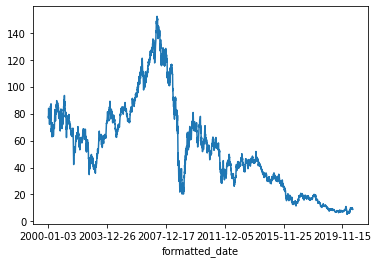

In [26]:
data.close.plot()

In [27]:
mm, sstd = data.close.pct_change().mean(), data.close.pct_change().std()

In [28]:
mm, sstd

(-3.0362694738882632e-05, 0.027893721179395946)

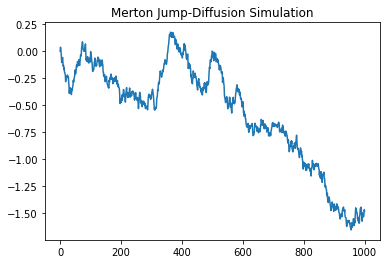

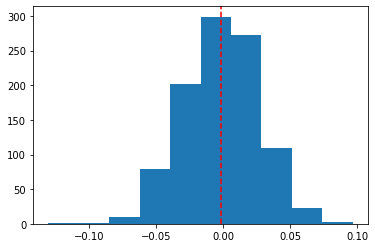

In [100]:
# x = brownian_motion_log_returns(1, 0.000001, 1000)
# x = geometric_brownian_motion_log_returns(1, 0, 0.0312, 1000)

# delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N
x = geometric_brownian_motion_jump_diffusion_log_returns(1, mm, sstd, 0.1, -0.01, 0.001, 1000)

plt.figure()
plt.title('Merton Jump-Diffusion Simulation')
plt.plot(x.cumsum())
plt.show()

plt.figure()
plt.hist(x)
plt.axvline(x.mean(), ls = '--', color = 'red')
plt.show()

In [101]:
prices_simulation = convert_to_prices(x, 100)
hlo_simulated = model_prices.predict(np.log(prices_simulation))
hloc_simulated = np.concatenate((np.exp(hlo_simulated), np.expand_dims(prices_simulation, -1)), axis=1)
volume_simulated = np.exp(model_volume.predict(np.log(hloc_simulated)))
dataset_simulated = pd.DataFrame({
    'high': hloc_simulated[:, 0],
    'open': hloc_simulated[:, 1],
    'low': hloc_simulated[:, 2],
    'close': hloc_simulated[:, 3],
    'volume': volume_simulated.flatten()
},
    index = [datetime.today() + timedelta(days=x) for x in range(len(hloc_simulated))])

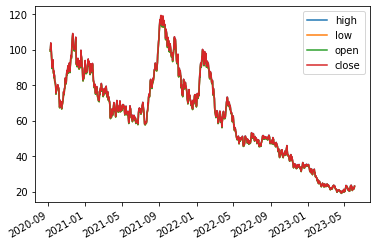

In [102]:
dataset_simulated[['high', 'low', 'open', 'close']].plot()

In [103]:
dataset_simulated = ohclv_to_features(dataset_simulated)

# Modeling

In [104]:
%%time

dataset_warmup = dataset[str(START_YEAR):str(WARMUP_END)]
dataset_train = dataset[str(WARMUP_END):str(END_YEAR)]
imp, IMPORTANT_FEATURES = calculate_important_features(dataset_warmup)

X_train, Y_train, P_train, T_train = createXY(dataset_train[IMPORTANT_FEATURES], dataset_train['close'], training=True)
X_test, Y_test, P_test, T_test = createXY(dataset_simulated[IMPORTANT_FEATURES], dataset_simulated['close'])

mmcs, pred_prs = train_and_evaluate_n_times(X_train, Y_train, X_test, Y_test)
bagging_strategies, bagging_returns = backtest_predictions(pred_prs, P_test)

CPU times: user 15.4 s, sys: 245 ms, total: 15.7 s
Wall time: 16.5 s


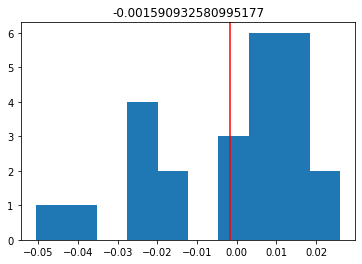

In [105]:
visualize_mmcs(mmcs)

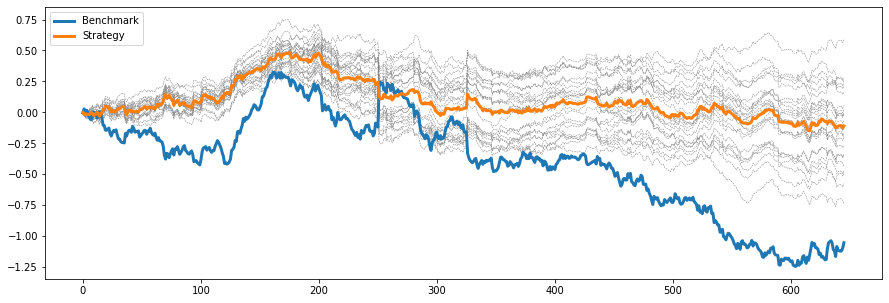

In [106]:
visualize_backtests(bagging_strategies, P_test)

In [107]:
calculate_all_metrics(
    P_test, 
    np.array(bagging_returns), 
    T_test,
    mmcs, 
    pred_prs)

{'benchmark_mean_returns': -0.0016298815517014648,
 'strategy_mean_returns': -0.00016988540921789337,
 'benchmark_sharpe': -0.7976058116154443,
 'benchmark_sharpe_smart': -0.7854766881420959,
 'strategy_sharpe': -0.1754275958955971,
 'strategy_sharpe_smart': -0.17352309077439634,
 'probabilistic_sharpe_ratio': 1.0,
 'deflated_sharpe_ratio': 1.7503916760528936e-125,
 'information_ratio': 1.5076257253160383,
 'minimum_track_record_length': 8.09670397911453,
 'benchmark_drawdown': -1.48,
 'strategy_drawdown': -0.57,
 'mmc_mean': -0.001590932580995177,
 'mmc_std': 0.02061330549368497,
 'mmc_sharpe': -0.07717988662626528,
 'model_certainty': 0.02122105263157903}

In [108]:
column_importance_ts = {}
for column in imp.T.columns:
    if column not in column_importance_ts:
        column_importance_ts[column] = [imp.T[column]['mean']]
    else:
        column_importance_ts[column].append(imp.T[column]['mean'])
column_importance_ts = pd.DataFrame.from_dict(column_importance_ts)

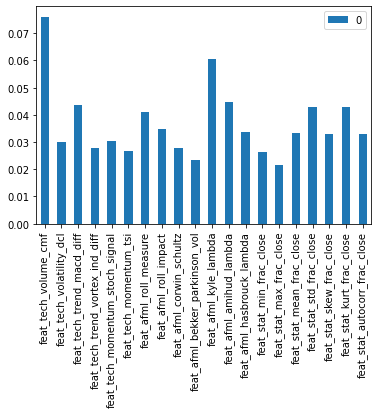

In [109]:
column_importance_ts.T.plot.bar()